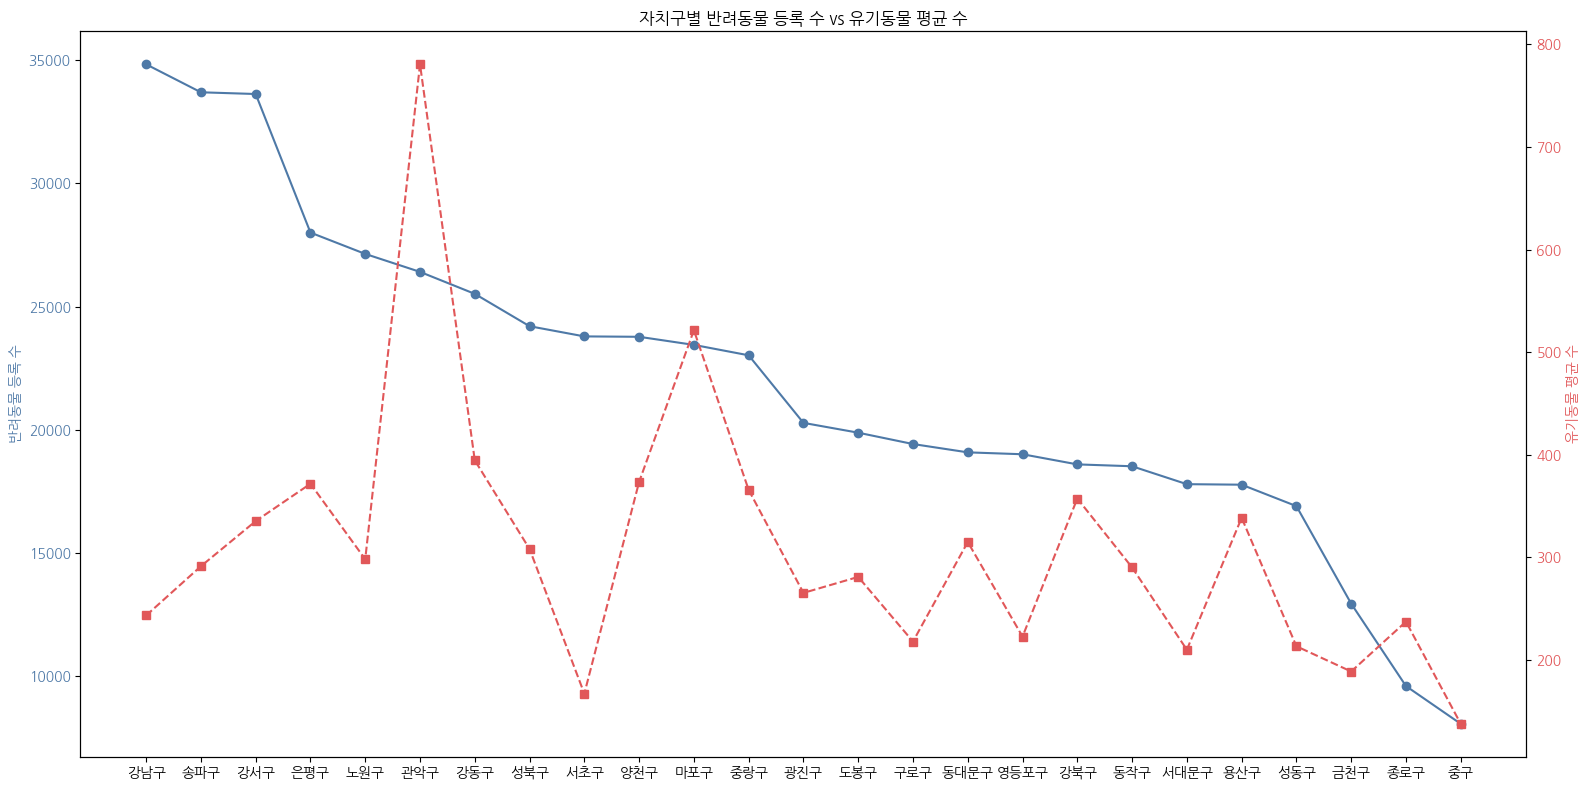

In [5]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

# ▶️ .env 파일의 환경변수 불러오기
load_dotenv("/home/jiming/dev_ws/eda-repo-3/env")
host = os.getenv("DB_HOST")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")

# ▶️ MySQL 연결
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:3306/{database}")

# ▶️ 데이터 조회 (등록현황) ========================================
query = """
SELECT 
    sigungu as 시군구,
    total_registered as 총등록_누계
FROM companion_animal_registration
WHERE sido = '서울특별시'
ORDER BY total_registered DESC
"""
df_register = pd.read_sql(query, engine)

df_register.columns = ['시군구','총등록_누계']




# ▶️ 유기동물 마리수 가져오기 =======================================
query = """
SELECT *
FROM seoul_abandonment_statistics
ORDER BY district_name
"""
df = pd.read_sql(query, engine)
df.columns =['id','자치구', '2016', '2017', '2018', '2019', '2020', '삭제']

# 필요없는 column 제거하기
df = df.drop(columns =['id', '삭제'])

# 평균값 구하기
df['평균'] = df[['2016', '2017', '2018', '2019', '2020']].mean(axis=1)

# 필요없는 column 제거하기
df = df.drop(columns =['2016', '2017','2018','2019','2020'])

df_sorted = df.sort_values(by='평균', ascending=False)



# 두개 데이터 병합하기 =============================================
df_register = df_register.rename(columns={'시군구':'자치구'})
df_merged = pd.merge(df_register, df_sorted, on='자치구', how='inner')
df_merged.columns=['자치구', '반려동물_등록수', '유기동물_평균']



# 두개 병합하기 (scale 다르게) ================================
df_merged_sorted = df_merged.sort_values(by='반려동물_등록수', ascending=False)

plt.figure(figsize=(16, 8))

# 첫 번째 y축
ax1 = plt.gca()
ax1.plot(df_merged_sorted['자치구'], df_merged_sorted['반려동물_등록수'],color='#4e79a7', marker='o', label='반려동물 등록 수')
ax1.set_ylabel('반려동물 등록 수', color='#4e79a7')
ax1.tick_params(axis='y', labelcolor='#4e79a7')

# 두 번째 y축
ax2 = ax1.twinx()
ax2.plot(df_merged_sorted['자치구'], df_merged_sorted['유기동물_평균'], color='#e15759',marker='s', linestyle='--', label='유기동물 평균 수')
ax2.set_ylabel('유기동물 평균 수', color='#e15759')
ax2.tick_params(axis='y', labelcolor='#e15759')

# 공통 x축
plt.xticks(rotation=45)
plt.title('자치구별 반려동물 등록 수 vs 유기동물 평균 수')
plt.tight_layout()

plt.show()


